This notebook illustrates how to apply the transformer metric to a single burst time series. 

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

In [2]:
import torch

References:

- CNN story: https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
- ASF Search: https://search.asf.alaska.edu/#/?polygon=POINT(143.3641%20-5.3821)&zoom=13.000&center=143.364,-5.425&resultsLoaded=true&granule=OPERA_L2_RTC-S1_T009-019294-IW2_20240603T084748Z_20240603T133726Z_S1A_30_v1.0&maxResults=250&dataset=OPERA-S1&productTypes=RTC

In [3]:
from datetime import datetime

def acq_date_float(burst_date):
    """
    Convert a burst date to a float representing years since January 1, 2014.

    Args:
        burst_date: Date object, datetime object, or date string (YYYY-MM-DD format)

    Returns:
        float: Number of years since January 1, 2014
    """
    reference_date = datetime(2014, 1, 1)

    if isinstance(burst_date, str):
        burst_date = datetime.strptime(burst_date, '%Y-%m-%d')
    elif hasattr(burst_date, 'date'):
        burst_date = datetime.combine(burst_date.date(), datetime.min.time())
    elif not isinstance(burst_date, datetime):
        burst_date = datetime.combine(burst_date, datetime.min.time())

    delta = burst_date - reference_date
    years_since_2014 = delta.days / 365.25

    return years_since_2014

# Parameters

In [4]:
# Papau New Guinea Landslide
BURST_ID = "T009_019294_IW2"
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")

# Los Angeles Angeles Fire - Pacific Palisades Burst
BURST_ID = 'T071-151228-IW3'
EVENT_TS = pd.Timestamp("2025-01-08", tz="utc")

LOOKBACK_STRATEGY = 'multi_window'

N_PRE_IMAGES = 20
APPLY_LOGIT = False

##Check --- should this be tweaked?
N_PRE_IMGS_PER_YEAR = 3

# Download Data

In [5]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  316


,opera_id,acq_datetime,polarization,track_number,geometry,url_vh,url_vv,dedup_id
0,OPERA_L2_RTC-S1_T071-151228-IW3_20170714T13522...,2017-07-14 13:52:23+00:00,VV+VH,71,"POLYGON ((-118.24294 34.16123, -119.12038 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20170714T135223Z
1,OPERA_L2_RTC-S1_T071-151228-IW3_20170726T13522...,2017-07-26 13:52:24+00:00,VV+VH,71,"POLYGON ((-118.24282 34.16157, -119.12028 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20170726T135224Z
2,OPERA_L2_RTC-S1_T071-151228-IW3_20170807T13522...,2017-08-07 13:52:24+00:00,VV+VH,71,"POLYGON ((-118.24409 34.16068, -119.12155 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20170807T135224Z
3,OPERA_L2_RTC-S1_T071-151228-IW3_20170819T13522...,2017-08-19 13:52:25+00:00,VV+VH,71,"POLYGON ((-118.24333 34.1613, -119.12079 34.28...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20170819T135225Z
4,OPERA_L2_RTC-S1_T071-151228-IW3_20170912T13522...,2017-09-12 13:52:26+00:00,VV+VH,71,"POLYGON ((-118.24311 34.16022, -119.12059 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20170912T135226Z


In [6]:
def get_anniversary_indices(timestamps: list[pd.Timestamp], event_time: pd.Timestamp, n_imgs_per_year=N_PRE_IMGS_PER_YEAR) -> list[int]:
    ts_series = pd.Series(timestamps)
    base_anniv = event_time - pd.Timedelta(days=365)
    years = sorted(set(ts.year for ts in timestamps if ts.year < event_time.year))
    result = []

    for y in years:
        anniv = base_anniv.replace(year=y)
        candidates = ts_series[ts_series < anniv]
        if not candidates.empty:
            closest = (candidates - anniv).abs().nsmallest(n_imgs_per_year)
            result.extend(closest.index.tolist())

    return sorted(result)

# Determine which images we need to load (pre/post filtering)
acq_dts = df_rtc_ts.acq_datetime.tolist()
post_index = [k for (k, date) in enumerate(acq_dts) if date >= EVENT_TS][0]
post_date = acq_dts[post_index]
post_date

Timestamp('2025-01-09 13:52:54+0000', tz='UTC')

In [7]:
if LOOKBACK_STRATEGY == 'immediate':
    pre_indices = [k for (k, date) in enumerate(acq_dts) if date < EVENT_TS][-N_PRE_IMAGES:]
elif LOOKBACK_STRATEGY == 'multi_window':
    pre_indices = get_anniversary_indices(acq_dts, post_date)
else:
    raise NotImplementedError('needs to be immediate or multi_window')
pre_dates = [acq_dts[k] for k in pre_indices]
pre_dates
    

[Timestamp('2017-12-17 13:52:25+0000', tz='UTC'),
 Timestamp('2017-12-29 13:52:25+0000', tz='UTC'),
 Timestamp('2018-01-10 13:52:24+0000', tz='UTC'),
 Timestamp('2018-12-12 13:52:32+0000', tz='UTC'),
 Timestamp('2018-12-24 13:52:32+0000', tz='UTC'),
 Timestamp('2019-01-05 13:52:31+0000', tz='UTC'),
 Timestamp('2019-12-25 13:51:56+0000', tz='UTC'),
 Timestamp('2019-12-31 13:52:38+0000', tz='UTC'),
 Timestamp('2020-01-06 13:51:56+0000', tz='UTC'),
 Timestamp('2020-12-25 13:52:44+0000', tz='UTC'),
 Timestamp('2020-12-31 13:52:02+0000', tz='UTC'),
 Timestamp('2021-01-06 13:52:43+0000', tz='UTC'),
 Timestamp('2021-12-14 13:52:08+0000', tz='UTC'),
 Timestamp('2021-12-20 13:52:50+0000', tz='UTC'),
 Timestamp('2022-01-01 13:52:49+0000', tz='UTC'),
 Timestamp('2022-12-15 13:52:56+0000', tz='UTC'),
 Timestamp('2022-12-27 13:52:55+0000', tz='UTC'),
 Timestamp('2023-01-08 13:52:55+0000', tz='UTC'),
 Timestamp('2023-12-10 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-22 13:53:00+0000', tz='UTC'),


In [8]:
# Combine all indices we need to load
indices_to_load = sorted(pre_indices + [post_index])
print(f"Loading {len(indices_to_load)} images out of {len(df_rtc_ts)} total images")
print(f"Pre-event indices: {pre_indices}")
print(f"Post-event index: {post_index}")

# Create filtered dataframe and URL lists for only the images we need
df_rtc_filtered = df_rtc_ts.iloc[indices_to_load].copy()
urls_vv_filtered = df_rtc_filtered.url_vv.tolist()
urls_vh_filtered = df_rtc_filtered.url_vh.tolist()

Loading 22 images out of 316 total images
Pre-event indices: [12, 13, 14, 42, 43, 44, 85, 86, 87, 143, 144, 145, 201, 202, 203, 232, 233, 234, 262, 263, 264]
Post-event index: 295


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [9]:
# Load only the filtered images (much more memory efficient!)
arrs_vv, profiles = read_asf_rtc_image_data(urls_vv_filtered)
arrs_vh, _ = read_asf_rtc_image_data(urls_vh_filtered)

Loading RTC data: 100%|████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.43it/s]


In [10]:
#arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv, n_jobs=10, interp_method='bilinear')
#arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh, n_jobs=10, interp_method='bilinear')

In [10]:
# Create mapping from original indices to filtered array indices
original_to_filtered = {orig_idx: filtered_idx for filtered_idx, orig_idx in enumerate(indices_to_load)}
pre_indices_filtered = [original_to_filtered[idx] for idx in pre_indices]
post_index_filtered = original_to_filtered[post_index]

print(f"Original pre-indices: {pre_indices}")
print(f"Filtered pre-indices: {pre_indices_filtered}")
print(f"Original post-index: {post_index}")
print(f"Filtered post-index: {post_index_filtered}")


Original pre-indices: [12, 13, 14, 42, 43, 44, 85, 86, 87, 143, 144, 145, 201, 202, 203, 232, 233, 234, 262, 263, 264]
Filtered pre-indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Original post-index: 295
Filtered post-index: 21


In [11]:
acq_dates = [acq_date_float(date) for date in pre_dates]

In [12]:
acq_dates

[3.9589322381930185,
 3.991786447638604,
 4.024640657084189,
 4.944558521560575,
 4.97741273100616,
 5.0102669404517455,
 5.979466119096509,
 5.9958932238193015,
 6.012320328542095,
 6.981519507186858,
 6.997946611909651,
 7.014373716632443,
 7.950718685831622,
 7.967145790554415,
 8.0,
 8.952772073921972,
 8.985626283367557,
 9.018480492813142,
 9.938398357289527,
 9.971252566735114,
 10.004106776180699]

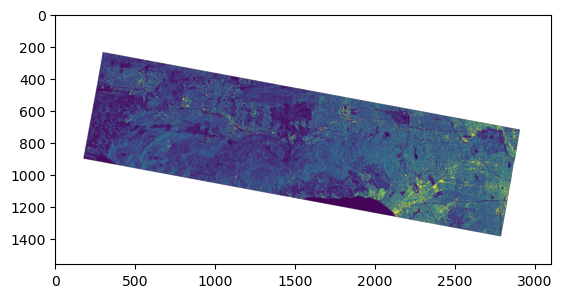

In [13]:
plt.imshow(arrs_vh[-1], vmin=0, vmax=.15)

In [14]:
from distmetrics.model_load import ALLOWED_MODELS
ALLOWED_MODELS

['transformer_original',
 'transformer_optimized',
 'transformer_optimized_fine',
 'transformer_anniversary_trained',
 'transformer_anniversary_trained_optimized',
 'transformer_anniversary_trained_optimized_fine']

In [15]:
# Load the external model with trained weights
model_path = '/scratch/opera-dist-ml/users/jmauro/dist-s1-model/models/transformer_09-16-2025_16-25_final.pth'
checkpoint = torch.load(model_path, map_location='cpu')

# Extract model config if available, otherwise use config_redux.yml
if 'model_config' in checkpoint:
    model_config = checkpoint['model_config']
else:
    # Load config from config_redux.yml
    import yaml
    with open('../config_redux.yml', 'r') as f:
        config = yaml.safe_load(f)
    model_config = config['model_config']

print(f"Using model config: {model_config}")

# Create a temporary config file
import tempfile
import json
import os

with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    json.dump(model_config, f)
    config_path = f.name

# Load the transformer model 
transformer = load_transformer_model(
    lib_model_token='external',
    model_cfg_path=config_path,
    model_wts_path=model_path
)

# Clean up temp file
os.unlink(config_path)

print(f"Loaded model with {transformer.num_parameters()} parameters")

/tmp/ipykernel_1078308/1421565480.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')
/gpfs/scratch/opera-dist-ml/use

Using model config: {'type': 'transformer', 'patch_size': 8, 'input_size': 16, 'data_dim': 128, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 4, 'dim_feedforward': 768, 'max_seq_len': 21, 'dropout': 0.2, 'activation': 'gelu'}
Loaded model with 3301122 parameters


In [28]:
# Use raw data values without the logit transofmation from v0 or v1 burst applications
pre_imgs_vv = arrs_vv[:-1]
pre_imgs_vh = arrs_vh[:-1]

#Data stats (sanity check)
# print(f"Using raw gamma naught values")
# print(f"VV ranges (first 3): {[(np.nanmin(arr), np.nanmax(arr)) for arr in pre_imgs_vv[:3]]}")
# print(f"VH ranges (first 3): {[(np.nanmin(arr), np.nanmax(arr)) for arr in pre_imgs_vh[:3]]}")
# print(f"NaN counts - VV: {[np.isnan(arr).sum() for arr in pre_imgs_vv[:3]]}")
# print(f"Total pixels per image: {pre_imgs_vv[0].size}")

Using raw gamma naught values
VV ranges (first 3): [(np.float32(0.001192598), np.float32(703.78284)), (np.float32(0.00043895285), np.float32(766.65784)), (np.float32(0.00075697806), np.float32(834.2575))]
VH ranges (first 3): [(np.float32(0.0001098831), np.float32(178.87363)), (np.float32(8.590358e-05), np.float32(174.66153)), (np.float32(0.00013990482), np.float32(164.48235))]
NaN counts - VV: [np.int64(3044772), np.int64(3044759), np.int64(3045980)]
Total pixels per image: 4840661


In [19]:
# Use raw gamma naught values for post-event data too
post_vv = arrs_vv[-1]
post_vh = arrs_vh[-1]

print(f"Post-event data:")
print(f"VV range: {(np.nanmin(post_vv), np.nanmax(post_vv))}")
print(f"VH range: {(np.nanmin(post_vh), np.nanmax(post_vh))}")
print(f"NaN counts - VV: {np.isnan(post_vv).sum()}, VH: {np.isnan(post_vh).sum()}")

Post-event data:
VV range: (np.float32(0.00042039048), np.float32(2469.1216))
VH range: (np.float32(1.6901728e-05), np.float32(162.8171))
NaN counts - VV: 3046047, VH: 3046047


In [42]:
# Landslide
if BURST_ID == "T009_019294_IW2":
    sy = np.s_[1250:1500]
    sx = np.s_[400:750]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

else:

    pre_vv_c = [arr for arr in pre_imgs_vv]
    pre_vh_c = [arr for arr in pre_imgs_vh]

    post_vv_c = post_vv
    post_vh_c = post_vh

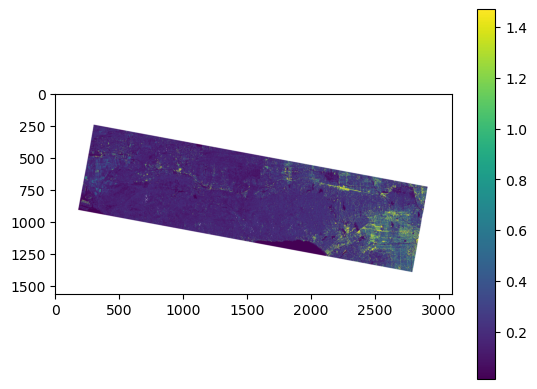

In [65]:
data = pre_vv_c[-1]

# Replace infs with NaN
data = np.where(np.isfinite(data), data, np.nan)

# Clip outliers
vmin, vmax = np.percentile(data[~np.isnan(data)], [2, 98])
data_clipped = np.clip(data, vmin, vmax)

# Create a colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Mask NaNs for plotting
data_masked = np.ma.masked_invalid(data_clipped)

plt.imshow(data_masked, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [45]:
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c,
    pre_vh_c,
    post_vv_c,
    post_vh_c,
    acq_dts_float=acq_dates,
    stride=2,
    agg="max",
    batch_size=32,  ##TODO: Try higher batch size or memory strategy back to low -- running out of gattaca GPU memory
    memory_strategy="low",  
)

Chips Traversed:   0%|                                                                       | 0/37274 [00:00<…

/gpfs/scratch/opera-dist-ml/users/jmauro/dist-s1-model/notebooks/distmetrics/tf_metric.py:78: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  m_dist = DiagMahalanobisDistance2d(dist=z_score, mean=mu, std=sigma)


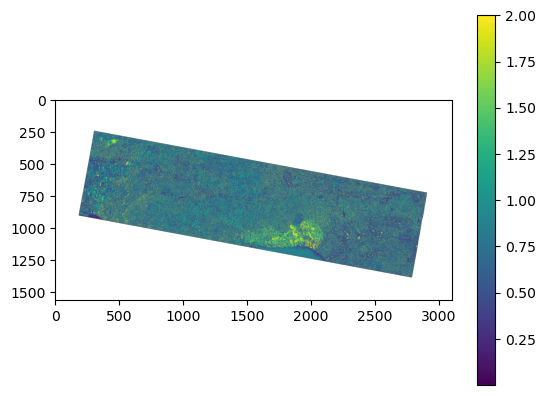

In [68]:
plt.imshow(dist_ob.dist, vmax=2)
plt.colorbar()

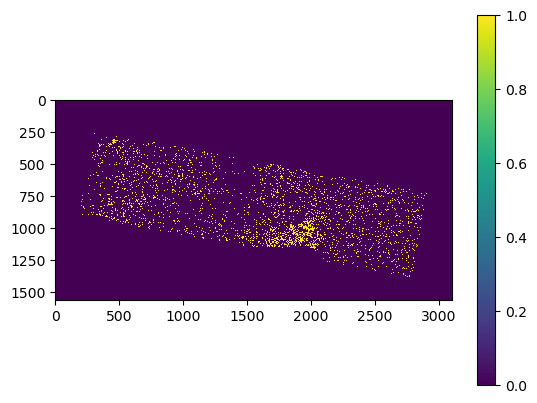

In [76]:
plt.imshow(dist_ob.dist > 1.5, vmax=1, interpolation="none")
plt.colorbar()
##Big TODO -- the results change a lot based on what we set as threshold. Need to discuss this choice

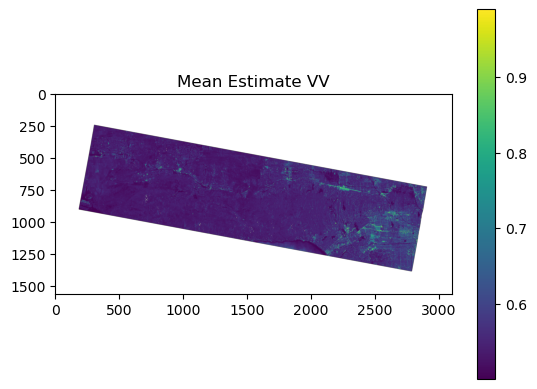

In [77]:
from scipy.special import expit

plt.title("Mean Estimate VV")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

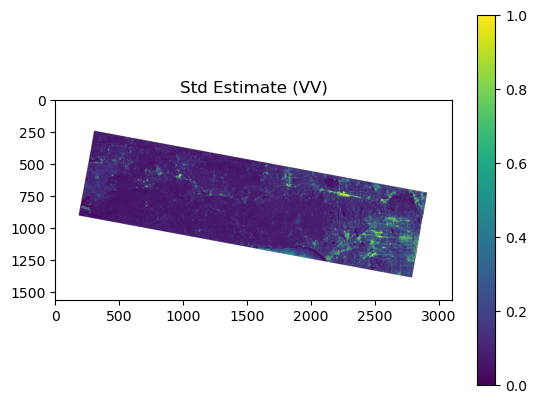

In [79]:
plt.title("Std Estimate (VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()